In [ ]:
# Langgraph DAG setup teaching code.
# al.nevarez@ March, 4, 2025

# just using message state to show where we are in a dag

# 1. a basic hello world
# 2. and an example to emulate Neha's chat flow use case

# hello world example is a varient from here:
# https://blog.madhukaraphatak.com/exploring-langgraph-part-1

In [ ]:
!pip install -U langgraph

## simple example with 2 hello world nodes

In [ ]:
from langgraph.graph import MessagesState

# for readability, use a type hint, the function expects an argument named state and this should be an instance of MessagesState class
def hello_world_agent(state:MessagesState):
    return {"messages":["Hello world. I'm inside hello world agent 1"]}

def hello_world_agent2(state:MessagesState):
    return {"messages":["Hello world. I'm inside hello world agent 2"]}

In [ ]:
from langgraph.graph import END, START, StateGraph

# add nodes
graph_builder = StateGraph(MessagesState)

graph_builder.add_node("hello_world_agent",hello_world_agent)
graph_builder.add_node("hello_world_agent2",hello_world_agent2)

# add edges
graph_builder.add_edge(START,"hello_world_agent")
graph_builder.add_edge("hello_world_agent", "hello_world_agent2")
graph_builder.add_edge("hello_world_agent2",END)

In [ ]:
graph = graph_builder.compile()

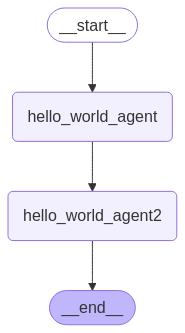

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
for event in graph.stream({"messages": ["apples"]}):
    for value in event.values():
        print(value)
        print()
    for keys in event.keys():
        print(keys)
        print()
    for items in event.items():
        print(items)
        print()
    print("-----")


{'messages': ["Hello world. I'm inside hello world agent 1"]}

hello_world_agent

('hello_world_agent', {'messages': ["Hello world. I'm inside hello world agent 1"]})

-----
{'messages': ["Hello world. I'm inside hello world agent 2"]}

hello_world_agent2

('hello_world_agent2', {'messages': ["Hello world. I'm inside hello world agent 2"]})

-----


## Neha's example

No LLM or real data used here.. Mainly just constructed a DAG with a couple conditional edges and some random functions to simulate what a real function might return. So we can test the flow easily at the end.

DAG diagram in cell 280 below.

 Neha provided the following requirements:

* AI agent processes website chats to qualify leads using Anthropic API and integration with Hubspot & Zoominfo for lead enrichment
* Real-time chat routing to SDRs on Slack
* Automated meeting scheduling by checking calendar availability
* AI-driven company insights shared on Slack to help SDRs sell smarter

In [ ]:
# start a new Langgraph graph
!pip install -U langgraph
from langgraph.graph import END, START, StateGraph
from langgraph.graph import MessagesState

graph_builder = StateGraph(MessagesState)

In [ ]:
# a few simple functions to emulate a response about being qualified, asking for a call, and scheduling a call
# in a real agent, these would call an anthopic classifier, respond to an agent asking prospect to schedule, and a scheduler returning a status
# but i just emulate these with the following random functions

import random

def qualify():
    """Randomly classifies the input question."""
    return random.choice(["qualified", "not qualified"])

def ask_for_call():
    """Randomly classifies the input question."""
    return random.choice(["Ask for call", "No ask for call"])

def meeting_scheduled():
    """Randomly classifies the input question."""
    return random.choice(["Meeting scheduled", "No meeting scheduled"])

In [ ]:
# in a real agent these may be like the lead function upon entering a node or an agent
# for now we're just using the Message state to help us track where in the agent we are
# each of these are called later when we construct the nodes

from langgraph.graph import MessagesState

def read_chat_agent(state:MessagesState):
    return {"messages":["Inside the read chat node"]}

def enrich_with_hubspot_agent(state:MessagesState):
    return {"messages":["Inside Hubspot enrichment node"]}

def enrich_with_zoominfo_agent(state:MessagesState):
    return {"messages":["Inside Zoominfo enrichment node"]}

# the next function need to invoke some pretend functionality to test if the prospect is qualified or not
def qualify_test_agent(state):
    qualified = qualify()  # check our random function above
    # store result in the state
    return {"qualified_test_result": qualified, "messages": [f"Qualify test node & conditional edge result: {qualified}"]}

def route_chat_to_slack_agent(state:MessagesState):
    return {"messages":["Inside routing chat to slack node"]}

# the next function need to invoke some pretend functionality to test if the agent is requesting a call or not
def ask_for_call_slack_agent(state):
    asked_for_call = ask_for_call()  # check our random function above
    # store result in the state
    return {"ask_for_call": asked_for_call, "messages": [f"Inside check if sdr wants call or not: {asked_for_call}"]}

# the next function need to invoke some pretend functionality to test if the prospect has scheduled a call or not
def meeting_scheduler_agent(state):
    meeting_scheduled_check = meeting_scheduled()  # check our random function above
    # store result in the state
    return {"meeting_scheduled": meeting_scheduled_check, "messages": [f"Inside test if prospect scheduled meeting: {meeting_scheduled_check}"]}

def get_ai_insights_agent(state:MessagesState):
    return {"messages":["Get ai driven insights"]}


In [ ]:
# add nodes (which are like agents) to the graph
graph_builder = StateGraph(MessagesState)

graph_builder.add_node("read_chat",read_chat_agent)
graph_builder.add_node("enrich_with_hubspot",enrich_with_hubspot_agent)
graph_builder.add_node("enrich_with_zoominfo",enrich_with_zoominfo_agent)
graph_builder.add_node("qualify_test", qualify_test_agent)
graph_builder.add_node("route_chat_to_sdr_via_slack", route_chat_to_slack_agent)
graph_builder.add_node("ask_for_call", ask_for_call_slack_agent)
graph_builder.add_node("meeting_scheduler", meeting_scheduler_agent)
graph_builder.add_node("get_ai_insights", get_ai_insights_agent)


In [ ]:
# A set of functions that get the result of the random functions and pass a value to be used by
# the condition edges.  basically i'm just passing the same values, but we need  functions like this
# for the conditional edge tests.

def decide_next_node_post_qualify(state):
  return "qualified" if state.get('qualified_test_result') == 'qualified' else 'not_qualified'

def decide_next_node_post_ask_for_call(state):
  return "Ask for call" if state.get('ask_for_call') == 'Ask for call' else 'No ask for call'

def decide_next_node_post_meeting_scheduler(state):
  return "Meeting scheduled" if state.get('meeting_scheduled') == 'Meeting scheduled' else 'No meeting scheduled'


In [ ]:
# Add conditional edges
# this multi-agent has 3 places it has to make a decision following a node
# each below starts with a node, and the function that gets value that becomes key for where to route next

graph_builder.add_conditional_edges(
    "qualify_test",
    decide_next_node_post_qualify,
    {
        "qualified": "route_chat_to_sdr_via_slack",
        "not_qualified": END
    }
)

graph_builder.add_conditional_edges(
    "ask_for_call",
    decide_next_node_post_ask_for_call,
    {
        "Ask for call": "meeting_scheduler",
        "No ask for call": END
    }
)

graph_builder.add_conditional_edges(
    "meeting_scheduler",
    decide_next_node_post_meeting_scheduler,
    {
        "Meeting scheduled": "get_ai_insights",
        "No meeting scheduled": END
    }
)

In [ ]:
# add edges between the nodes
graph_builder.set_entry_point("read_chat")
graph_builder.add_edge("read_chat","enrich_with_zoominfo")
graph_builder.add_edge("enrich_with_zoominfo","enrich_with_hubspot")
graph_builder.add_edge("enrich_with_hubspot","qualify_test")
graph_builder.add_edge("route_chat_to_sdr_via_slack","ask_for_call")
# Note: no need to add an edge linking meeting_scheduler here, as it's already there in conditional edges above.
graph_builder.add_edge("get_ai_insights",END)


In [ ]:
graph = graph_builder.compile()

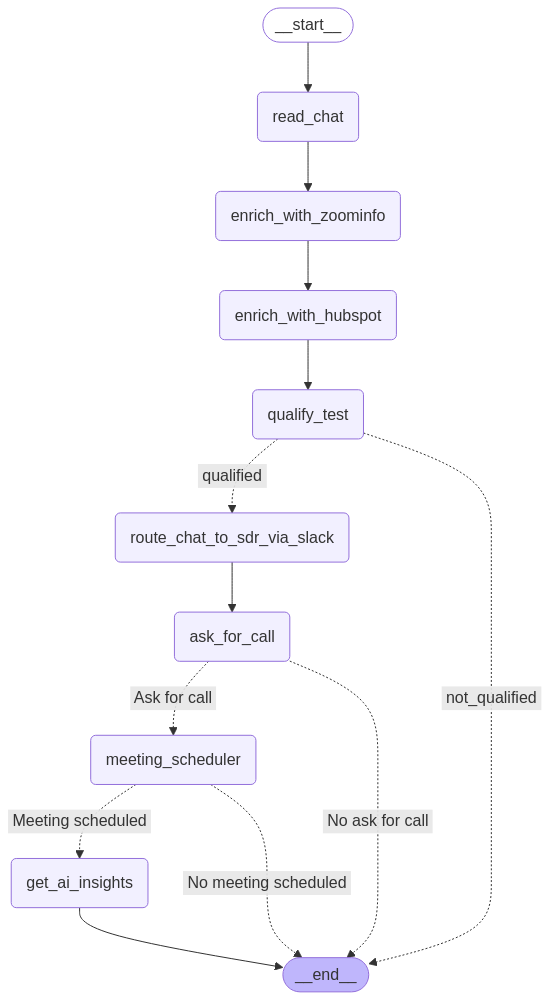

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    print("something is wrong")
    pass

In [ ]:
# run this cell over and over again to get a run through the agents.
# it will use random outcomes for each of the conditional edges

for event in graph.stream({"messages": ["This is pretend input chat"]}):
    for value in event.values():
        print(value)

{'messages': ['Inside the read chat node']}
{'messages': ['Inside Zoominfo enrichment node']}
{'messages': ['Inside Hubspot enrichment node']}
{'messages': ['Qualify test node & conditional edge result: not qualified']}


In [ ]:
# print out more attributes of the graph
for event in graph.stream({"messages": ["This is pretend input chat 2"]}):
    for value in event.values():
        print(value)
        print()
    for keys in event.keys():
        print(keys)
        print()
    for items in event.items():
        print(items)
        print()
    print("-----")


{'messages': ['Inside the read chat node']}

read_chat

('read_chat', {'messages': ['Inside the read chat node']})

-----
{'messages': ['Inside Zoominfo enrichment node']}

enrich_with_zoominfo

('enrich_with_zoominfo', {'messages': ['Inside Zoominfo enrichment node']})

-----
{'messages': ['Inside Hubspot enrichment node']}

enrich_with_hubspot

('enrich_with_hubspot', {'messages': ['Inside Hubspot enrichment node']})

-----
{'messages': ['Qualify test node & conditional edge result: not qualified']}

qualify_test

('qualify_test', {'messages': ['Qualify test node & conditional edge result: not qualified']})

-----
